In [12]:
import numpy as np
import pygam
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import itertools
import scipy as sp
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import seaborn as sb
import pygraphviz
plt.style.use('default')

import sys
sys.path.append("../../scripts/")
import visutil

In [13]:
FIG_DIR = "./"
DATA_DIR = "../../data/pancreas/"
try:
    my_purple = matplotlib.colors.LinearSegmentedColormap.from_list("MyPurple", ['purple', 'purple', ])
    matplotlib.colormaps.register(cmap = my_purple)
    my_red = matplotlib.colors.LinearSegmentedColormap.from_list("MyRed", ['red', 'red', ])
    matplotlib.colormaps.register(cmap = my_red)
    my_grey = matplotlib.colors.LinearSegmentedColormap.from_list("MyGrey", ['#595959', '#595959', ])
    matplotlib.colormaps.register(cmap = my_grey)
except:
    pass

In [14]:
adata = ad.AnnData(np.load(DATA_DIR + "X.npy"))
adata.obs["dpt"] = np.load(DATA_DIR + "dpt.npy")
adata.var["gene"] = np.array(pd.read_csv(DATA_DIR + "genes.txt"))
adata.var.index = adata.var["gene"]
adata.obs["leiden"] = np.load(DATA_DIR + "leiden.npy")
adata.obs["cluster"] = np.array(pd.read_csv(DATA_DIR + "clusters.csv", index_col = 0))
adata.obsm["X_umap"] = np.load(DATA_DIR + "X_umap.npy")
fates = pd.read_csv(DATA_DIR + "fates.csv", index_col = 0)

In [15]:
is_stress_gene = (adata.var.gene == "Fos") | (adata.var.gene == "Egr1")
is_stress_interaction = np.array([(x | y) for (x, y) in list(itertools.product(is_stress_gene, is_stress_gene))])

adata.varm["J"] = np.load(DATA_DIR + "J.npy")
G = np.load(DATA_DIR + "G.npy")
adata.uns["G"] = np.swapaxes(G.reshape(-1, adata.shape[1], adata.shape[1]), 1, 2).reshape(-1, adata.shape[1]**2) # fix Julia orientation

# filter out stress genes and stress interactions
adata = adata[:, ~is_stress_gene]
adata.varm["J"] = adata.varm["J"][:, ~is_stress_gene]
adata.uns["G"] = adata.uns["G"][:, ~is_stress_interaction]

In [16]:
# per cluster
J_beta_net =adata.varm["J"].copy()*0
for (i, j) in [("Pdx1", "Nkx6-1"), ("Nkx6-1", "Arx"), ("Arx", "Nkx6-1"), ("Arx", "Pdx1"), ("Isl1", "Arx")]:
    J_beta_net[np.where(adata.var.gene == i)[0][0], np.where(adata.var.gene == j)[0][0]] = 1
J_beta_net_closure = (sp.linalg.expm(J_beta_net) > 0) - sp.eye(J_beta_net.shape[0])

/tmp/ipykernel_271281/449643961.py:5: DeprecationWarning: scipy.eye is deprecated and will be removed in SciPy 2.0.0, use numpy.eye instead
  J_beta_net_closure = (sp.linalg.expm(J_beta_net) > 0) - sp.eye(J_beta_net.shape[0])


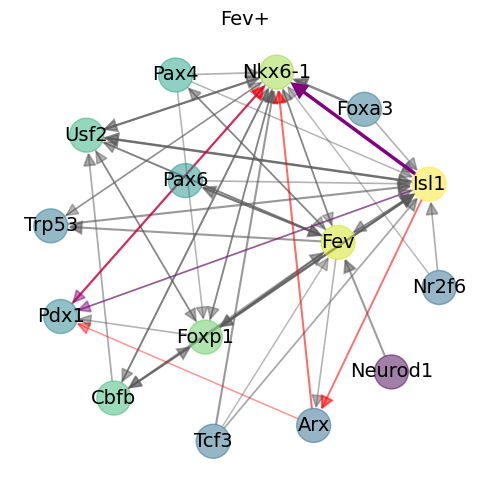

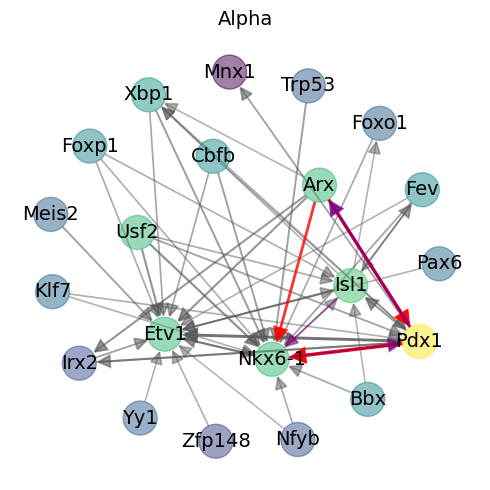

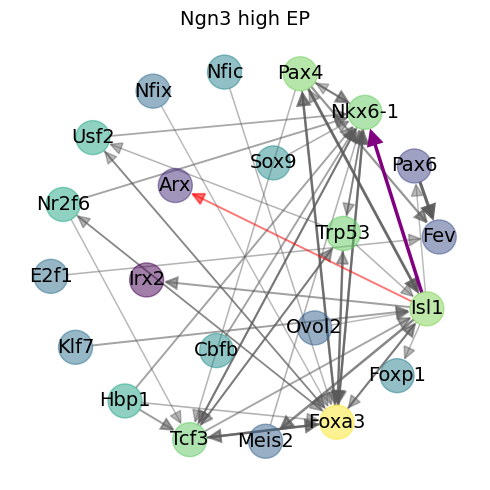

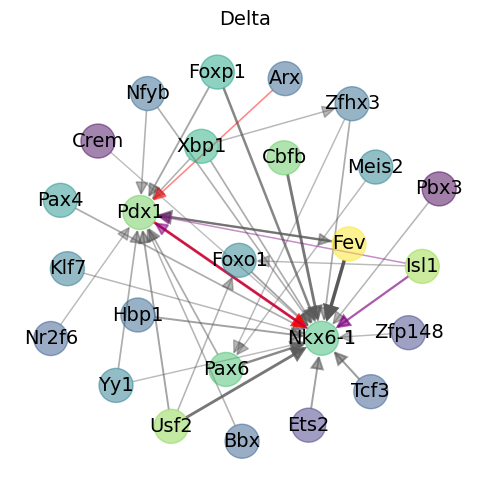

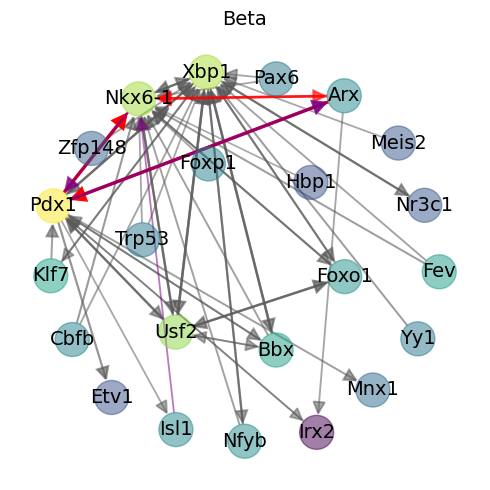

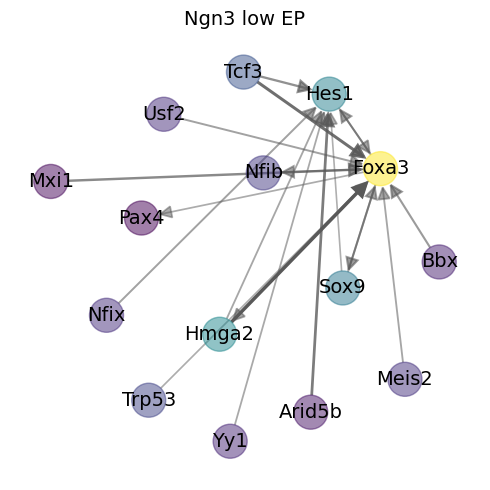

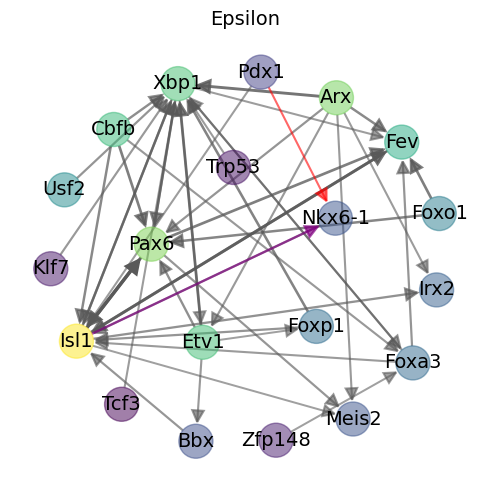

In [17]:
for k in pd.unique(adata.obs.cluster):
    A = adata.uns["G"][adata.obs.cluster == k, :].mean(0).reshape(adata.shape[1], adata.shape[1])
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    # nx.set_edge_attributes(g, {(i, j) : J_beta_net_closure[i, j] for (i, j) in g.edges}, name = "ref")
    nx.set_edge_attributes(g, {(i, j) : J_beta_net[i, j] if J_beta_net[i, j] > 0 else -J_beta_net_closure[i, j] for (i, j) in g.edges}, name = "ref")
    plt.figure(figsize = (5, 5))
    visutil.draw(g, adata.var.gene, thresh = 0.99, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
    plt.gca().axis("off")
    plt.title(k, fontsize = 14)
    plt.tight_layout()
    plt.savefig(FIG_DIR + "pancreas_cluster_avg_network_%s_filtered.pdf" % k)

In [18]:
# top-k out edges
def outedge_counts(A, cutoff = 1_000):
    cutoff = np.sort(A.flatten())[::-1][cutoff]
    A[A <= cutoff] = 0
    return np.sum(A > 0, -1)

def outedge_eigen_centrality(A):
    g = nx.DiGraph(A)
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    nodes, centrality = zip(*nx.get_node_attributes(g,'centrality').items())
    return centrality

In [19]:
# write genelists (top 25, eigencentrality)
for k in adata.obs.cluster.unique():
    A = adata.uns["G"][adata.obs.cluster == k, :].mean(0).reshape(adata.shape[1], adata.shape[1])
    centrality = outedge_eigen_centrality(A.reshape(adata.shape[1], adata.shape[1]))
    pd.DataFrame({"gene" : adata.var.gene[np.argsort(centrality)[::-1][0:25]]}).to_csv(DATA_DIR + "genelist_cluster_%s.csv" % k, header = True, index = False)

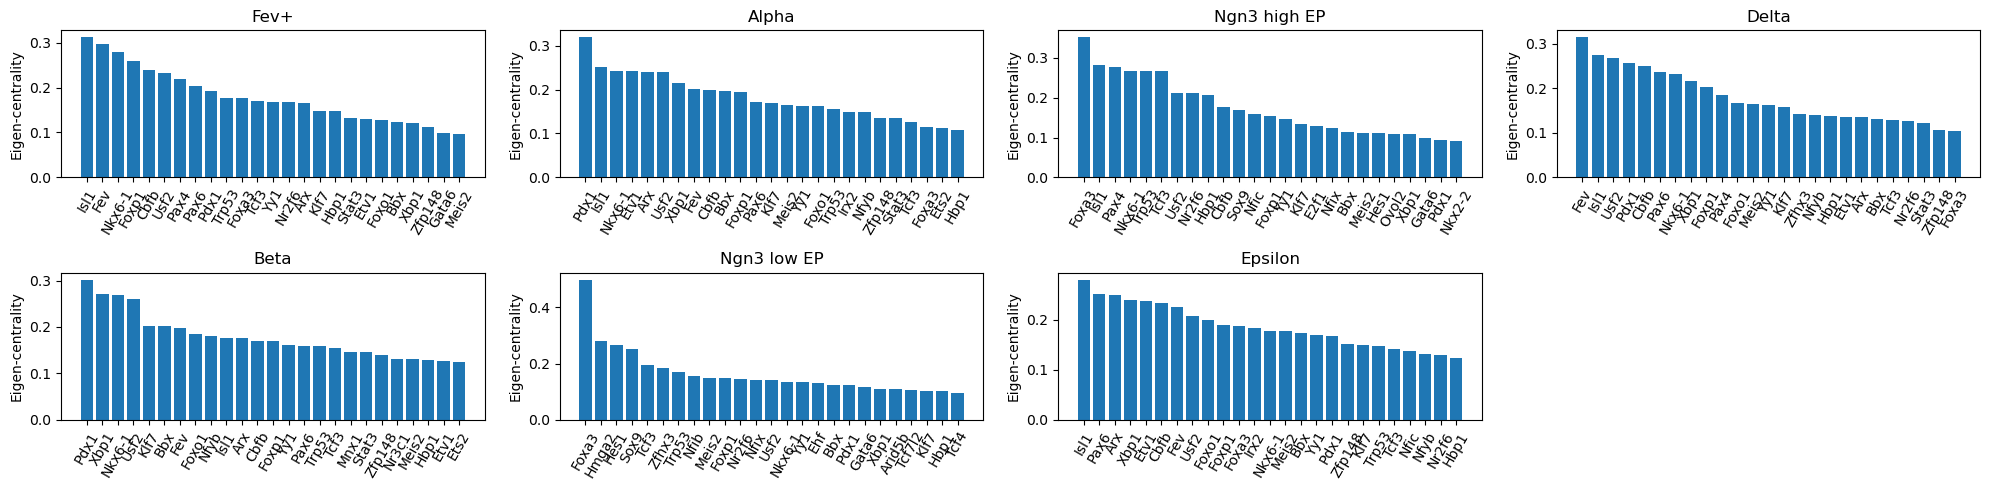

In [20]:
plt.figure(figsize = (20, 5))
for (i, k) in enumerate(pd.unique(adata.obs.cluster)):
    A = adata.uns["G"][adata.obs.cluster == k, :].mean(0).reshape(adata.shape[1], adata.shape[1])
    # counts = outedge_counts(A.reshape(adata.shape[1], adata.shape[1]))
    # idx = np.argsort(counts)[::-1][0:25]
    centrality = np.array(outedge_eigen_centrality(A.reshape(adata.shape[1], adata.shape[1])))
    idx = np.argsort(centrality)[::-1][0:25]
    plt.subplot(2, 4, i+1)
    plt.bar(range(len(idx)), centrality[idx])
    plt.xticks(range(len(idx)), adata.var.gene[idx], rotation = 60);
    plt.title(k)
    plt.ylabel("Eigen-centrality")
plt.tight_layout()
plt.savefig(FIG_DIR + "pancreas_cluster_centrality.pdf")

(-21.313005, 533.812005, -30.663365000000002, 525.710365)

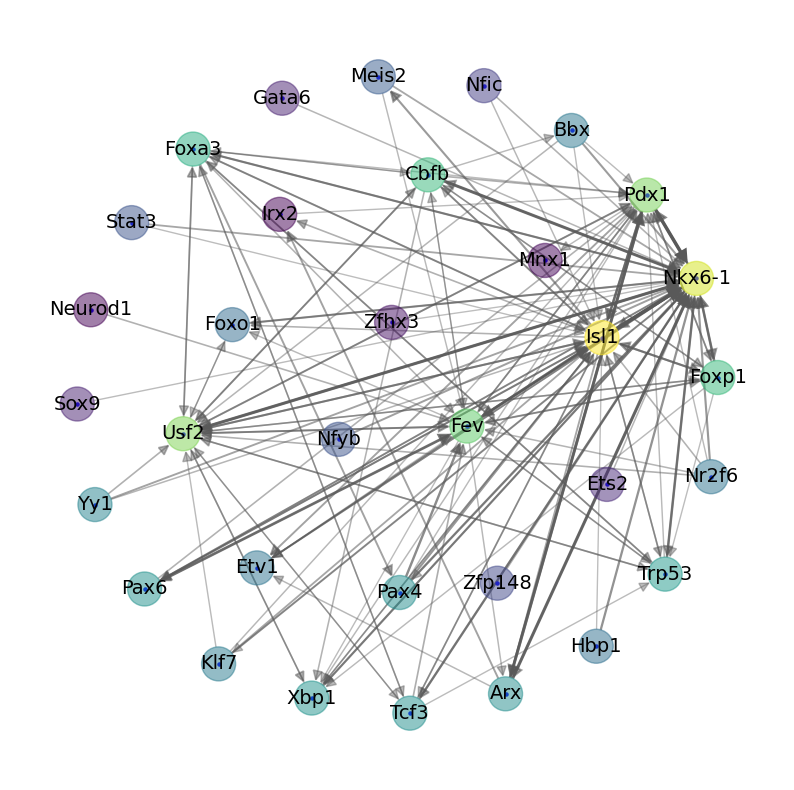

In [21]:
g = nx.DiGraph(np.mean(adata.uns["G"][adata.obs.dpt < 0.9, :], axis = 0).reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
# get weights from g
edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
weights = np.array(list(weights))
weights /= np.max(weights)
# node and edgelist
nl = list(g.nodes())
el = list(g.edges())
edge_idx = np.where(weights > np.quantile(weights, 0.975))[0]
edgelist = [el[i] for i in edge_idx]

node_idx = list(set(itertools.chain(*edgelist)))
nodelist = [nl[i] for i in node_idx]
# take subgraph
g_sub = g.subgraph(nodelist)

# now plot
edges,weights = zip(*nx.get_edge_attributes(g_sub,'weight').items())
weights = np.array(list(weights))
weights /= np.quantile(weights, 0.999)
weights = np.minimum(1, weights)
edge_idx2 = np.where([e in edgelist for e in g_sub.edges()])[0]

fig = plt.figure(figsize = (10, 10))
# pos = nx.shell_layout(g_sub)
# pos = nx.spring_layout(g_sub, iterations = 250, seed = 0)
pos = nx.nx_agraph.graphviz_layout(g_sub, prog = 'fdp')
nx.draw_networkx_nodes(g_sub, pos, node_color = "b", node_size = 5)
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = weights[edge_idx2], alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = matplotlib.colormaps["MyGrey"], edge_vmin = 0.1, node_size = 600)
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, labels = {i : adata.var.gene[i] for i in g_sub.nodes()}, font_size = 14);
nodes, centrality = zip(*nx.get_node_attributes(g_sub,'centrality').items())
centrality /= np.max(centrality)
nx.draw_networkx_nodes(g, pos, nodelist = nodes, node_color = centrality, cmap = matplotlib.colormaps["viridis"], alpha = 0.5, node_size = 600)
plt.axis("off")

(-0.5, 2530.5, 152.5, -0.5)

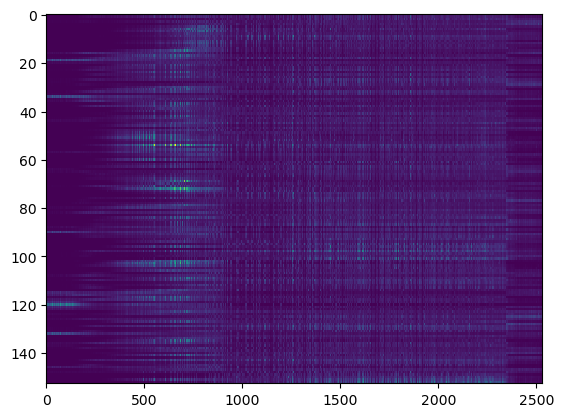

In [22]:
G_tensor = adata.uns["G"].reshape(-1, adata.shape[1], adata.shape[1])
G_subset = np.vstack([G_tensor[:, i, j] for (i, j) in edgelist])
plt.imshow(G_subset[:, np.argsort(adata.obs.dpt)], interpolation = "none")
plt.axis("auto")

In [23]:
import seaborn as sb
gams = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, x) for x in G_subset]
G_gam = np.vstack([g.predict(adata.obs.dpt) for g in gams])
row_perm = np.argsort(np.median(G_gam * np.array(adata.obs.dpt).reshape(1, -1), -1))

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


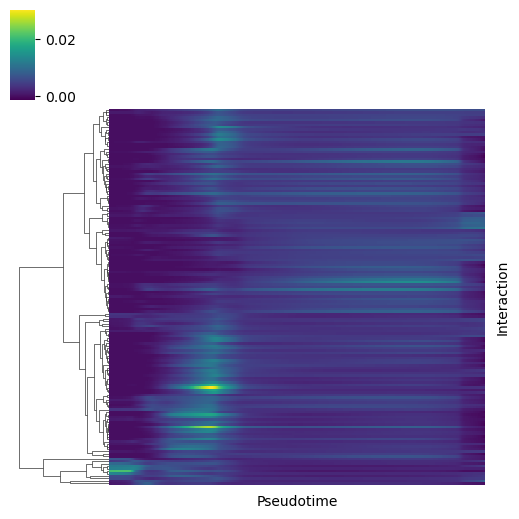

In [24]:
import scipy
cg = sb.clustermap(G_gam[:, np.argsort(adata.obs.dpt)][row_perm, :], row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", rasterized = True)
cg.ax_heatmap.set_xlabel("Pseudotime")
cg.ax_heatmap.set_ylabel("Interaction")
cg.savefig(FIG_DIR + "pancreas_interactions_clustermap.pdf")

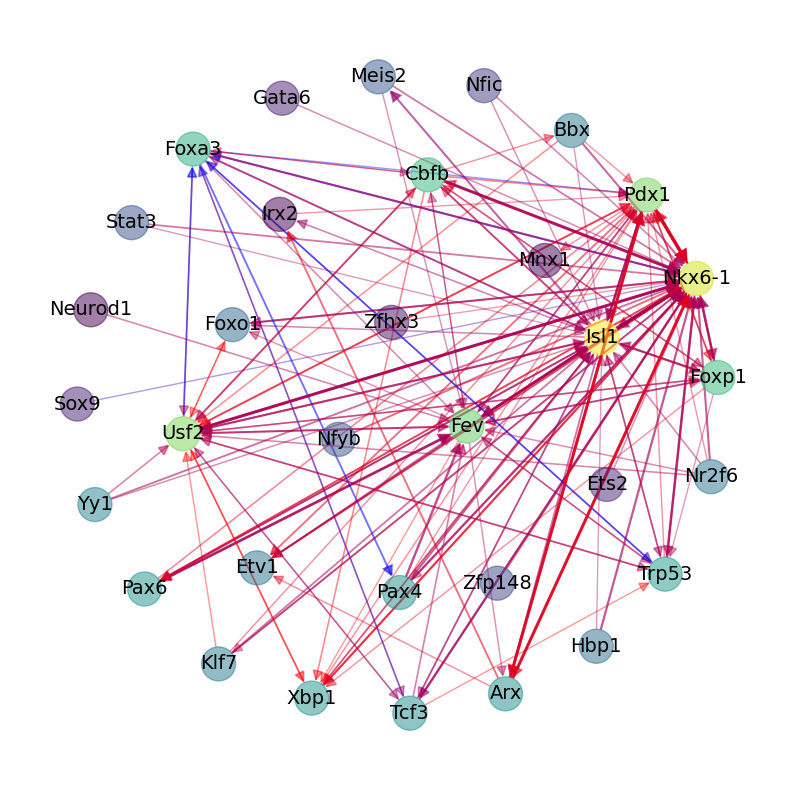

In [25]:
active_dpt = np.array(adata.obs.dpt)[np.argsort(G_gam, -1)[:, -1]]
blue_red1 = matplotlib.colors.LinearSegmentedColormap.from_list("BlueRed1", ['blue', 'red'])
fig = plt.figure(figsize = (10, 10))
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = active_dpt, alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = blue_red1, node_size = 600)
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, labels = {i : adata.var.gene[i] for i in g_sub.nodes()}, font_size = 14);
nx.draw_networkx_nodes(g, pos, nodelist = nodes, node_color = centrality, cmap = matplotlib.colormaps["viridis"], alpha = 0.5, node_size = 600)
plt.axis("off")
plt.savefig(FIG_DIR + "pancreas_interactions_color_network.pdf")

In [26]:
def top_correlates(fates, Gs):
    G_corrs = np.array([((1+sp.stats.pearsonr(fates,g)[0])/2)*np.mean(g) for g in Gs.T])
    # G_corrs = np.array([np.dot(fates, g) for g in Gs.T])
    G_corrs[np.isnan(G_corrs)] = 0
    return G_corrs

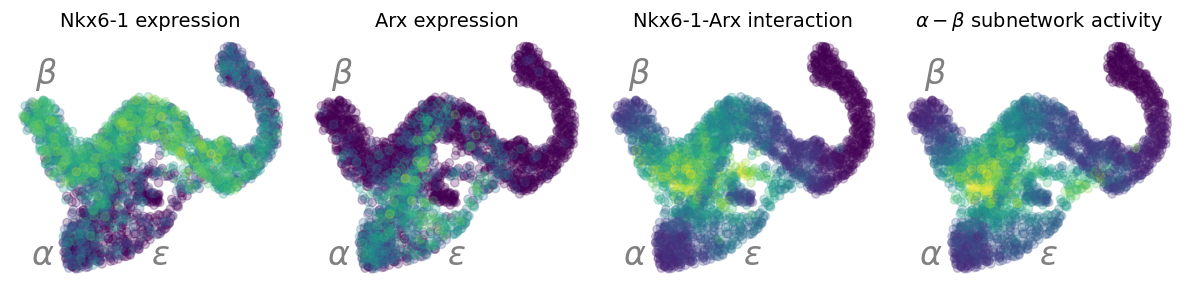

In [27]:
plt.figure(figsize = (12, 3))
plt.subplot(1, 4, 3)
g_j, g_i = "Arx", "Nkx6-1"
x_i = adata.X[:, adata.var.gene == g_i].flatten()
x_j = adata.X[:, adata.var.gene == g_j].flatten()
g = adata.uns["G"].reshape(-1, adata.shape[1], adata.shape[1])[:, adata.var.gene == g_i, adata.var.gene == g_j]
plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], 
            c = g, alpha = 0.25, vmax = np.quantile(g, 0.99))
plt.axis("off")
plt.annotate("$\\beta$", (-12.5, 7), fontsize = 24, color = "grey")
plt.annotate("$\\alpha$", (-13, -6.5), fontsize = 24, color = "grey")
plt.annotate("$\\varepsilon$", (0, -6.5), fontsize = 24, color = "grey")

plt.title("%s-%s interaction" % (g_i, g_j), fontsize = 14)
plt.subplot(1, 4, 1)
plt.scatter(adata.obsm["X_umap"][np.argsort(x_i), 0], adata.obsm["X_umap"][np.argsort(x_i), 1], 
            c = np.sort(x_i), alpha = 0.25)
plt.axis("off")
plt.annotate("$\\beta$", (-12.5, 7), fontsize = 24, color = "grey")
plt.annotate("$\\alpha$", (-13, -6.5), fontsize = 24, color = "grey")
plt.annotate("$\\varepsilon$", (0, -6.5), fontsize = 24, color = "grey")
plt.title("%s expression" % g_i, fontsize = 14)

plt.subplot(1, 4, 2)
plt.scatter(adata.obsm["X_umap"][np.argsort(x_j), 0], adata.obsm["X_umap"][np.argsort(x_j), 1], 
            c = np.sort(x_j), alpha = 0.25)
plt.axis("off")
plt.annotate("$\\beta$", (-12.5, 7), fontsize = 24, color = "grey")
plt.annotate("$\\alpha$", (-13, -6.5), fontsize = 24, color = "grey")
plt.annotate("$\\varepsilon$", (0, -6.5), fontsize = 24, color = "grey")
plt.title("%s expression" % g_j, fontsize = 14)

plt.subplot(1, 4, 4)
a = np.dot(adata.uns["G"], J_beta_net.flatten())
plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], 
            c = a, vmax = np.quantile(a, 0.99), alpha = 0.25)
plt.axis("off")
plt.annotate("$\\beta$", (-12.5, 7), fontsize = 24, color = "grey")
plt.annotate("$\\alpha$", (-13, -6.5), fontsize = 24, color = "grey")
plt.annotate("$\\varepsilon$", (0, -6.5), fontsize = 24, color = "grey")
plt.title("$\\alpha-\\beta$ subnetwork activity", fontsize = 14)
plt.tight_layout()

plt.savefig(FIG_DIR + "pancreas_subnetwork_interactions.pdf")

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


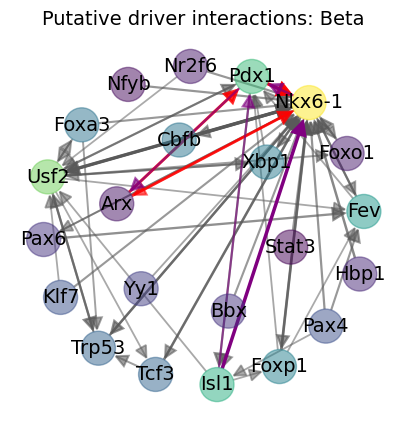

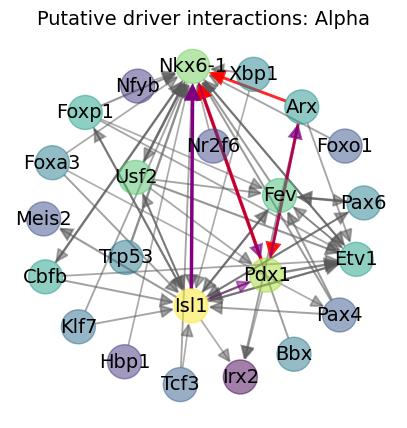

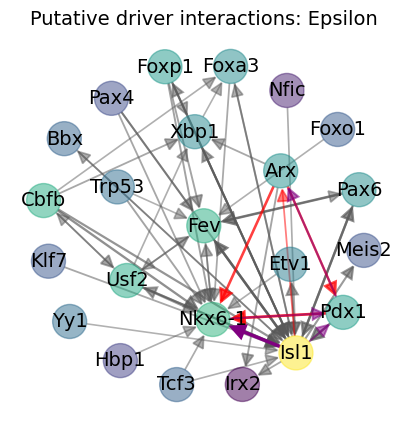

In [29]:
for f in ["Beta", "Alpha", "Epsilon"]:
    plt.figure(figsize = (5, 5))
    A = top_correlates(fates[f], adata.uns["G"])
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    nx.set_edge_attributes(g, {(i, j) : J_beta_net[i, j] if J_beta_net[i, j] > 0 else -J_beta_net_closure[i, j] for (i, j) in g.edges}, name = "ref")
    plt.axis("off")
    visutil.draw(g, adata.var.gene, thresh = 0.99, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
    plt.title("Putative driver interactions: %s" % f, fontsize = 14)
    plt.savefig(FIG_DIR + "pancreas_fate_interactions_%s.pdf" % f)

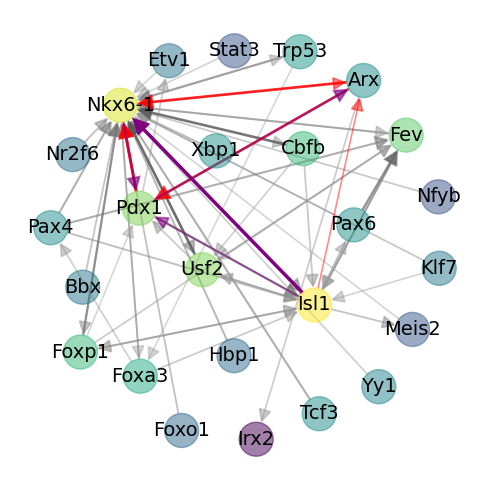

In [33]:
A = np.mean(adata.uns["G"][adata.obs.dpt < np.quantile(adata.obs.dpt, 0.9), :], axis = 0).reshape(adata.shape[1], adata.shape[1])
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
nx.set_edge_attributes(g, {(i, j) : J_beta_net[i, j] if J_beta_net[i, j] > 0 else -J_beta_net_closure[i, j] for (i, j) in g.edges}, name = "ref")
fig = plt.figure(figsize = (5, 5))
visutil.draw(g, adata.var.gene, thresh = 0.99, cmap_dict = {0 : "Greys", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=2")
plt.axis("off")
plt.tight_layout()
plt.savefig(FIG_DIR + "pancreas_static_network.pdf")